In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import random
import numpy as np
from qpthlocal.qp import QPFunction
from qpthlocal.qp import QPSolvers
from qpthlocal.qp import make_gurobi_model
import pickle
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
def make_matching_matrix(n):
    
    # n is num elements?
    lhs = list(range(n))
    rhs = list(range(n, 2*n))
    
    # n_vars is 1 per possible edge?
    n_vars = len(lhs)*len(rhs)
    # n_constraints is 1 for each lhs, 1 for each rhs, 1 per edge?
    n_constraints = len(lhs) + len(rhs) + n_vars
    A = np.zeros((n_constraints, n_vars))
    b = np.zeros((n_constraints))
    curr_idx = 0
    edge_idx = {}
    # get an index per edge
    for u in lhs:
        for v in rhs:
            edge_idx[(u,v)] = curr_idx
            curr_idx += 1
    # A has rows of 2n elements, followed by n^2 edges
    # A has cols of n^2 edges (so A @ x where x is edges)
    for u in lhs:
        for v in rhs:
            # for u, flip on coefficient for only its outgoing edges
            A[u, edge_idx[(u,v)]] = 1
            # for v, flip on coefficient for only its incoming edges
            A[v, edge_idx[(u,v)]] = 1
            # for the edge itself, flip on a single -1 at its point only
            A[len(lhs)+len(rhs)+edge_idx[(u,v)], edge_idx[(u,v)]] = -1
    
    # each element can have only 1 edge turned on in x
    for u in lhs:
        b[u] = 1
    for u in rhs:
        b[u] = 1
    
    
    return A, b


In [3]:
A, b = make_matching_matrix(10)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))


Academic license - for non-commercial use only


In [4]:
c_rand = -torch.rand(100, requires_grad=True)

In [5]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)

In [6]:
# Q is gamma * I
# we're not batching

match = func(gamma*torch.eye(A.shape[1]), c_rand, A, b, torch.Tensor(), torch.Tensor())

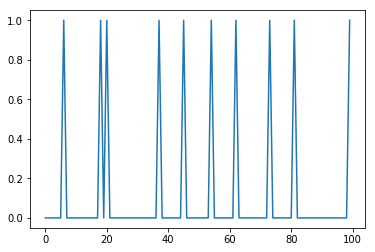

In [7]:
plt.plot(match.detach().numpy().flatten())

In [8]:
match.sum().backward()

## plan for dynamic setting:
- d types
- pool of elements curr_elem each with type (n at each time step)
- known edge weights between each type (?) e_weight (size n^2, recomputed at each time step)
- learned_coeff weights modify known edge weights (weights for each type, effectively pair of types, so d of these)
- perform match, true value of match is e_weight * x
- remove elements, recreate curr_elem, recreate e_weight

some thoughts: encoding type of pool of elements should be either LongTensor or one-hot so can get gradients after indexing



In [9]:
d=10
rand_d_weights = torch.rand(d, requires_grad=True)

In [10]:
n = 20
rand_types_pool = torch.randint(d,(n,))

In [11]:
curr_weights = rand_d_weights[rand_types_pool]

In [12]:
rand_e_weight = torch.rand(n,n) # in reality should be based on types (but not on weights)

In [13]:
modified_edge_weights = rand_e_weight + 0.5*(torch.unsqueeze(curr_weights,0) + torch.unsqueeze(curr_weights, 1))

In [14]:
A, b = make_matching_matrix(n)
A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()
gamma = 0.0001
model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))

In [15]:
func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params = model_params_quad)

In [16]:
resulting_match = func(gamma*torch.eye(A.shape[1]), -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(20,20)

In [17]:
modified_edge_weights

tensor([[1.4558, 0.9863, 1.7477, 1.0782, 1.1538, 1.1447, 0.8254, 0.7445, 0.4858,
         1.6091, 1.1025, 0.9954, 1.1483, 1.6326, 1.1131, 0.8770, 1.3635, 1.3961,
         1.0594, 1.4099],
        [1.1465, 0.7498, 1.0893, 0.5792, 0.6657, 1.1253, 1.5595, 1.0322, 0.5284,
         0.7414, 0.7796, 0.9755, 1.1351, 1.6758, 0.8242, 1.4176, 1.0123, 0.8485,
         1.3153, 1.5049],
        [0.8179, 1.1558, 1.8259, 0.7591, 0.5472, 1.5051, 0.9324, 1.3567, 0.9446,
         1.7309, 0.8466, 0.9469, 1.2551, 1.0355, 1.6315, 1.4085, 0.8552, 1.0624,
         1.0202, 0.8140],
        [1.0647, 1.2954, 0.6371, 0.2423, 0.5409, 0.7794, 0.9271, 0.5001, 0.5705,
         0.6300, 0.6683, 0.7666, 0.8131, 1.0918, 1.3293, 0.5871, 0.7006, 0.7326,
         1.1944, 0.5330],
        [0.4447, 0.5172, 0.8585, 0.1394, 0.4473, 0.7035, 0.5682, 1.2667, 0.8162,
         0.6281, 0.6932, 0.9213, 1.2182, 1.2398, 1.0565, 0.5215, 0.7625, 0.6063,
         0.8151, 0.7605],
        [0.4982, 1.1628, 1.3164, 0.5117, 1.1223, 0.3472, 1.3

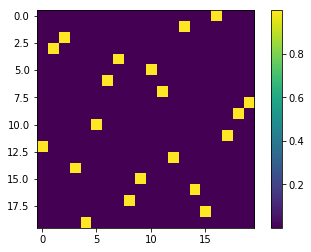

In [18]:
plt.imshow(resulting_match.detach().numpy())
plt.colorbar()

In [19]:
true_cost = torch.sum(resulting_match * rand_e_weight)

In [20]:
true_cost

tensor(18.2239, grad_fn=<SumBackward0>)

next step: decide on arrival/departure model -- presumably it should be type-dependent (one rare type with one really good edge to one other type)

In [21]:
type_arrival_rates = torch.rand(d)
type_departure_probs = torch.rand(d)

In [22]:
torch.max(resulting_match, 0).values != 1

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=torch.uint8)

In [23]:
new_match = resulting_match.clone()

In [24]:
new_match[19,15] = 0.0

In [25]:
new_match[16,0] = 0.0

In [26]:
torch.poisson(type_arrival_rates)

tensor([0., 0., 2., 1., 0., 0., 0., 0., 0., 0.])

In [27]:
def ind_counts_to_longs(arrival_counts):
    # optimize later
    results = []
    for i in range(arrival_counts.shape[0]):
        for j in range(arrival_counts[i].long().item()):
            results.append(i)
    return torch.LongTensor(results)

In [28]:
ind_counts_to_longs(torch.poisson(type_arrival_rates))

tensor([3, 3, 5, 7])

In [29]:
def step_simulation(current_elems, match_edges, d, type_arrival_rates, type_departure_probs, match_thresh=0.8):
    # first match elements
    pool_after_match = current_elems[torch.max(match_edges, 0).values <= match_thresh]
    
    # now handle departures
    if pool_after_match.shape[0] > 0:
        remaining_elements_depart_prob = type_departure_probs[pool_after_match]
        remain = torch.bernoulli(1 - remaining_elements_depart_prob).nonzero().view(-1)
        remaining_elements = pool_after_match[remain]
    else:
        remaining_elements = pool_after_match
    
    # now get new elements (poisson?)
    after_arrivals = torch.cat((remaining_elements, ind_counts_to_longs(torch.poisson(type_arrival_rates))))
    
    return after_arrivals

In [30]:
step_simulation(rand_types_pool, new_match, d, type_arrival_rates, type_departure_probs)

tensor([3, 3, 4, 4, 5, 5])

In [31]:
type_departure_probs[9] = 0.1

In [32]:
def edge_matrix(current_elems, e_weights_by_type):
    # compute the matrix of edge weights by type of each element
    # should actually be shaped as matrix, will be flattened later
    
    # optimize later
    edge_mat = torch.zeros((current_elems.shape[0], current_elems.shape[0]))
    for i in range(current_elems.shape[0]):
        for j in range(current_elems.shape[0]):
            u = current_elems[i]
            v = current_elems[j]
            edge_mat[i, j] = e_weights_by_type[u, v]
            
    return edge_mat

In [33]:
xx = torch.rand((d,d))
e_weights_by_type_rand = (xx + xx.t())

In [34]:
edge_matrix(rand_types_pool, e_weights_by_type_rand)

tensor([[1.7166, 1.7166, 0.8220, 0.8318, 0.6705, 1.6140, 0.8220, 0.9928, 0.6705,
         1.1326, 1.7166, 1.3104, 0.8220, 0.8133, 0.8133, 1.7166, 1.6140, 0.8220,
         0.9928, 1.3104],
        [1.7166, 1.7166, 0.8220, 0.8318, 0.6705, 1.6140, 0.8220, 0.9928, 0.6705,
         1.1326, 1.7166, 1.3104, 0.8220, 0.8133, 0.8133, 1.7166, 1.6140, 0.8220,
         0.9928, 1.3104],
        [0.8220, 0.8220, 1.7560, 1.1662, 1.2292, 0.9103, 1.7560, 0.6563, 1.2292,
         1.4839, 0.8220, 1.2010, 1.7560, 0.6249, 0.6249, 0.8220, 0.9103, 1.7560,
         0.6563, 1.2010],
        [0.8318, 0.8318, 1.1662, 0.1227, 0.5833, 0.8893, 1.1662, 0.8972, 0.5833,
         1.5762, 0.8318, 0.6131, 1.1662, 1.4667, 1.4667, 0.8318, 0.8893, 1.1662,
         0.8972, 0.6131],
        [0.6705, 0.6705, 1.2292, 0.5833, 0.7122, 0.7340, 1.2292, 0.6181, 0.7122,
         1.0419, 0.6705, 0.6903, 1.2292, 1.5025, 1.5025, 0.6705, 0.7340, 1.2292,
         0.6181, 0.6903],
        [1.6140, 1.6140, 0.9103, 0.8893, 0.7340, 1.1246, 0.9

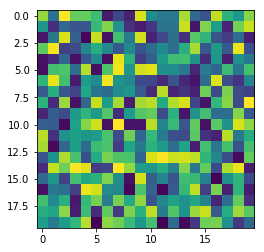

In [35]:
plt.imshow(rand_e_weight.numpy())

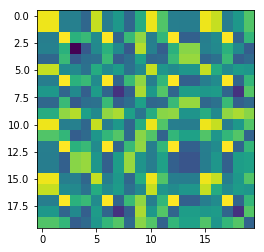

In [36]:
plt.imshow(edge_matrix(rand_types_pool, e_weights_by_type_rand).numpy())

In [37]:
# type_weights is the learned parameter

def compute_matching(current_elems, curr_type_weights, e_weights_by_type, gamma=0.00001):
    n = current_elems.shape[0]
    A, b = make_matching_matrix(n)
    A = torch.from_numpy(A).float()
    b = torch.from_numpy(b).float()
    # for some reason we need this randomness to end up with an actual matching
    e_weights = edge_matrix(current_elems, e_weights_by_type)
    jitter_e_weights = e_weights + 1e-4*torch.rand(n,n)
    #e_weights = torch.rand(n,n)
    model_params_quad = make_gurobi_model(A.detach().numpy(), b.detach().numpy(), None, None, gamma*np.eye(A.shape[1]))
    func = QPFunction(verbose=False, solver=QPSolvers.GUROBI, model_params=model_params_quad)
    
    Q_mat = gamma*torch.eye(A.shape[1])
    
    curr_elem_weights = curr_type_weights[current_elems]
    modified_edge_weights = jitter_e_weights + 0.5*(torch.unsqueeze(curr_elem_weights,0) + torch.unsqueeze(curr_elem_weights,1))
    # may need some negative signs
    resulting_match = func(Q_mat, -modified_edge_weights.view(-1), A, b, torch.Tensor(), torch.Tensor()).view(n,n)
    return resulting_match, e_weights

In [38]:
new_match, e_weights = compute_matching(rand_types_pool, rand_d_weights, e_weights_by_type_rand, gamma=1e-7)

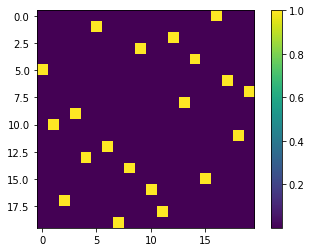

In [39]:
plt.imshow(new_match.detach().numpy())
plt.colorbar()

In [40]:
loss = torch.sum(new_match*e_weights)


In [41]:
loss.backward()